### Task 4. Object Tracking (3pt)

Given a short video sequence, persistently track the entities in said sequence across time until it goes out of frame, or the sequence terminates. You can find the aforementioned sequence in the `data/Task4` folder of this Overleaf project. You are free to use any tracking algorithm or pre-trained model for the task. With your implementation, answer the following two questions:

1. **Can you explain in detail, the process or algorithm you used to perform the tracking?**

2. **Additionally, can you provide a few example frames from your resulting sequence with the proper visualization to demonstrate the efficacy of your implementation?**

**Note**: By *tracking*, it means that you should be able to return the bounding box or centroid coordinate(s) of the entities in the video across the entire sequence.

#### Tips:
1. For the second part of the question, you should provide an example via a few adjacent frames so that the tracking performance is obvious. You should also use consistent labeling or color coding for your visualization corresponding to each unique entity for consistency if possible.

2. You should yield something like the following for your implementation and submission:

<div style="text-align: center; display: flex; justify-content: center; gap: 0;">
  <div style="text-align: center; margin: 0; padding: 0;">
    <img src='tracking_demo_f0.png' width="400" style="margin: 0; padding: 0;">
    <div style="margin: 0; padding: 0;">tracking_demo_f0.png</div>
  </div>
  <div style="text-align: center; margin: 0; padding: 0;">
    <img src='tracking_demo_f1.png' width="386" style="margin: 0; padding: 0;">
    <div style="margin: 0; padding: 0;">tracking_demo_f1.png</div>
  </div>
</div>


In [14]:
# Import Necessary Libraries
import numpy as np
import cv2
from IPython.display import Image, display
import os

In [2]:
def initialize_parameters():
    """
    Initialize parameters for Lucas-Kanade Optical Flow and Shi-Tomasi corner detection.

    Returns:
        tuple: Contains Lucas-Kanade parameters, Shi-Tomasi parameters,
               trajectory length, detection interval, and empty trajectories list.
    """
    # Parameters for Lucas-Kanade optical flow
    lucas_kanade_params = dict(
        winSize=(20, 20),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )

    # Parameters for Shi-Tomasi corner detection
    shi_tomasi_params = dict(
        maxCorners=25,
        qualityLevel=0.5,
        minDistance=5,
        blockSize=7
    )

    trajectory_length = 80       # Maximum length of trajectories
    detection_interval = 1       # Interval to detect new features
    trajectories = []            # List to store all trajectories

    return lucas_kanade_params, shi_tomasi_params, trajectory_length, detection_interval, trajectories

In [3]:
def create_output_directory(directory_name="figs"):
    """
    Create a directory to save example frames if it doesn't exist.

    Args:
        directory_name (str, optional): Name of the directory. Defaults to "figs".

    Returns:
        str: Path to the created directory.
    """
    current_dir = os.getcwd()
    output_dir = os.path.join(current_dir, directory_name)
    os.makedirs(output_dir, exist_ok=True)
    return output_dir


In [4]:
def create_output_directory(directory_name="figs"):
    """
    Create a directory to save example frames if it doesn't exist.

    Args:
        directory_name (str, optional): Name of the directory. Defaults to "figs".

    Returns:
        str: Path to the created directory.
    """
    current_dir = os.getcwd()
    output_dir = os.path.join(current_dir, directory_name)
    os.makedirs(output_dir, exist_ok=True)
    return output_dir


In [5]:
def get_video_capture(video_path):
    """
    Initialize video capture from the given file path.

    Args:
        video_path (str): Path to the video file.

    Returns:
        cv2.VideoCapture: Video capture object.

    Raises:
        FileNotFoundError: If the video file does not exist.
    """
    if not os.path.isfile(video_path):
        raise FileNotFoundError(f"Video file not found at: {video_path}")
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video file: {video_path}")
    
    return cap

In [6]:
def detect_features(gray_frame, mask, feature_params):
    """
    Detect Shi-Tomasi corners in the given grayscale frame.

    Args:
        gray_frame (np.ndarray): Grayscale image frame.
        mask (np.ndarray): Mask image to specify regions for detection.
        feature_params (dict): Parameters for Shi-Tomasi corner detection.

    Returns:
        np.ndarray or None: Detected feature points or None if no features found.
    """
    features = cv2.goodFeaturesToTrack(gray_frame, mask=mask, **feature_params)
    return features


In [7]:
def calculate_optical_flow(prev_gray, current_gray, p0, lk_params):
    """
    Calculate optical flow using Lucas-Kanade method.

    Args:
        prev_gray (np.ndarray): Previous grayscale frame.
        current_gray (np.ndarray): Current grayscale frame.
        p0 (np.ndarray): Previous points to track.
        lk_params (dict): Parameters for Lucas-Kanade optical flow.

    Returns:
        tuple: New points, status array, and error array.
    """
    p1, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, current_gray, p0, None, **lk_params)
    return p1, status, error

In [8]:
def filter_good_matches(p0, p0r, threshold=1):
    """
    Filter out the good optical flow points based on reverse tracking.

    Args:
        p0 (np.ndarray): Original points.
        p0r (np.ndarray): Reverse-tracked points.
        threshold (float, optional): Distance threshold to consider a match as good. Defaults to 1.

    Returns:
        np.ndarray: Boolean array indicating good matches.
    """
    distances = np.abs(p0 - p0r).reshape(-1, 2).max(-1)
    good_matches = distances < threshold
    return good_matches

In [9]:
def update_trajectories(trajectories, new_points, good_matches, max_length):
    """
    Update the list of trajectories with new points.

    Args:
        trajectories (list): Existing list of trajectories.
        new_points (np.ndarray): Newly tracked points.
        good_matches (np.ndarray): Boolean array indicating good matches.
        max_length (int): Maximum allowed length for a trajectory.

    Returns:
        list: Updated list of trajectories.
    """
    updated_trajectories = []
    for traj, point, is_good in zip(trajectories, new_points, good_matches):
        if not is_good:
            continue
        traj.append(tuple(point))
        if len(traj) > max_length:
            del traj[0]
        updated_trajectories.append(traj)
    return updated_trajectories

In [10]:
def draw_trajectories(image, trajectories):
    """
    Draw trajectories and current points on the image.

    Args:
        image (np.ndarray): Image on which to draw.
        trajectories (list): List of trajectories to draw.

    Returns:
        np.ndarray: Image with drawn trajectories and points.
    """
    for trajectory in trajectories:
        # Draw the trajectory as a green polyline
        if len(trajectory) > 1:
            points = np.int32(trajectory)
            cv2.polylines(image, [points], False, (0, 255, 0), 2)
        
        # Draw the current point as a red circle
        x, y = trajectory[-1]
        cv2.circle(image, (int(x), int(y)), 3, (0, 0, 255), -1)
    
    return image

In [15]:
def save_frame(image, frame_index, save_path):
    """
    Save the specified frame to the designated path.

    Args:
        image (np.ndarray): Image frame to save.
        frame_index (int): Index of the frame.
        save_path (str): Directory path to save the image.
    """
    filename = f"opticFlow_fr{frame_index}.jpg"
    destination = os.path.join(save_path, filename)
    cv2.imwrite(destination, image)
    
    print(f"Frame {frame_index} saved to {destination}")

In [12]:
def optical_flow_tracking(video_path, output_dir):
    """
    Perform optical flow tracking on the provided video file.

    Args:
        video_path (str): Path to the input video file.
        output_dir (str): Directory to save example frames.
    """
    # Initialize parameters
    lk_params, feature_params, traj_len, detect_intvl, trajectories = initialize_parameters()

    # Initialize video capture
    cap = get_video_capture(video_path)

    frame_index = 0
    prev_gray = None

    while True:
        # Read the next frame from the video
        ret, frame = cap.read()
        if not ret:
            print("End of video or cannot read the frame.")
            break

        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        output_frame = frame.copy()

        if trajectories:
            # Extract the last point of each trajectory for tracking
            p0 = np.float32([traj[-1] for traj in trajectories]).reshape(-1, 1, 2)

            # Calculate optical flow to get new points
            p1, status, _ = calculate_optical_flow(prev_gray, gray, p0, lk_params)

            # Calculate reverse optical flow for verification
            p0r, _, _ = calculate_optical_flow(gray, prev_gray, p1, lk_params)

            # Filter out good matches
            good = filter_good_matches(p0, p0r)

            # Update trajectories with good matches
            trajectories = update_trajectories(
                trajectories, p1.reshape(-1, 2), good, traj_len
            )

            # Draw updated trajectories on the output frame
            output_frame = draw_trajectories(output_frame, trajectories)

        # Detect new features at specified intervals
        if frame_index % detect_intvl == 0:
            mask = np.ones_like(gray)
            mask[:] = 255

            # Exclude regions where features are already being tracked
            for traj in trajectories:
                x, y = traj[-1]
                cv2.circle(mask, (int(x), int(y)), 5, 0, -1)

            # Detect new features to track
            new_features = detect_features(gray, mask, feature_params)
            if new_features is not None:
                for feature in new_features.reshape(-1, 2):
                    trajectories.append([tuple(feature)])

        # Save specific frames as examples
        if frame_index in [50, 51]:
            save_frame(output_frame, frame_index, output_dir)

        # Display the tracking result
        cv2.imshow('Lucas-Kanade Optical Flow Tracking', output_frame)

        # Handle keypresses
        key = cv2.waitKey(10) & 0xFF
        if key == 27:  # ESC key to exit
            print("ESC key pressed. Exiting...")
            break

        # Update variables for next iteration
        prev_gray = gray.copy()
        frame_index += 1

    # Release resources
    cap.release()
    cv2.destroyAllWindows()

Frame 50 saved to /home/jithin/Desktop/Perception_HW2/Q4/figs/opticFlow_fr50.jpg
Frame 51 saved to /home/jithin/Desktop/Perception_HW2/Q4/figs/opticFlow_fr51.jpg
End of video or cannot read the frame.


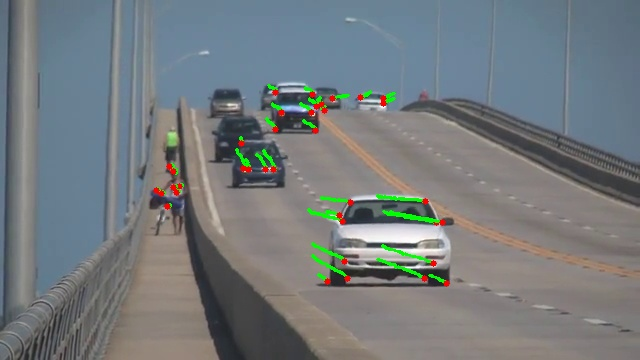

In [17]:
def main():
    """
    Main function to execute optical flow tracking.
    """
    # Define the path to the video file
    # Update the path below to point to your video file location
    video_file = r"tracking.mp4"

    # Define the directory to save example frames
    output_directory = create_output_directory("figs")

    try:
        optical_flow_tracking(video_file, output_directory)
    except Exception as e:
        print(f"An error occurred: {e}")
     
     
    
       
    # Define the folder path and the image file name
    folder_path = "figs"  # Replace with your folder path
    image_name = "opticFlow_fr50.jpg"   # Replace with your image file name

    # Combine folder path and image name
    image_path = os.path.join(folder_path, image_name)

    # Display the image
    try:
        display(Image(filename=image_path))
    except FileNotFoundError:
        print(f"Image not found at {image_path}. Please check the folder path and file name.")


if __name__ == "__main__":
    main()
